# **Section 1:** Data preparation.

In [ ]:
# Load the dataset from 'player-data-22-23.csv’ into a pandas DataFrame and print it along
# with its shape. 

import pandas as pd

# Load the dataset and print its shape and head
playerdata = pd.read_csv('player-data-22-23.csv')

In [ ]:
from tabulate import tabulate

# Get column names and data types
columns = playerdata.columns
data_types = playerdata.dtypes

# Create a list of tuples containing column names and data types
table_data = [(column, data_type) for column, data_type in zip(columns, data_types)]

# Print the table of column names and data types
print("Column Names and Data Types:")
print(tabulate(table_data, headers=["Feature Name", "Data Type"], tablefmt="grid"))

# Calculate statistics on data types
data_type_counts = data_types.value_counts().reset_index()
data_type_counts.columns = ["Data Type", "Count"]

# Print the table of data type statistics
print("\nData Type Statistics:")
print(tabulate(data_type_counts, headers=["Data Type", "Count"], tablefmt="grid"))


Column Names and Data Types:
+----------------+-------------+
| Feature Name   | Data Type   |
+================+=============+
| Player         | object      |
+----------------+-------------+
| Pos            | object      |
+----------------+-------------+
| Age            | int64       |
+----------------+-------------+
| Tm             | object      |
+----------------+-------------+
| G              | int64       |
+----------------+-------------+
| GS             | int64       |
+----------------+-------------+
| MP             | float64     |
+----------------+-------------+
| FG             | float64     |
+----------------+-------------+
| FGA            | float64     |
+----------------+-------------+
| FG%            | float64     |
+----------------+-------------+
| 3P             | float64     |
+----------------+-------------+
| 3PA            | float64     |
+----------------+-------------+
| 3P%            | float64     |
+----------------+-------------+
| 2P          

There are 3 categorical variables in the dataset:

1.   Player = player's name (dropped)
2.   Pos = player's position (encoded)
3. Tm = player's team (dropped)

Considering there are 5 positions in basketball, we can use one-hot encoding for that categorical variable. There are 30 teams in the NBA, however studying the value of a player has little relation to the team they play on so that column can be ignored for the study of a player's value. Finally, a player's name is completely irrelevant.

In [ ]:
# Copying the original dataframe into another one called 'train' 
# so we don't modify the original dataset
train = playerdata

# Drop the categorical columns with more than 10 unique values, this will drop
# Tm (the team a player plays for) and Player (players' names)

categorical_columns = train.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    if train[col].nunique() > 10:
        train.drop(col, axis=1, inplace=True)

# Perform one-hot enconding to a player's position (Pos)
train = pd.get_dummies(train, columns=['Pos'])

print("\nModified dataframe head: ")
train.head(1)


Modified dataframe head: 


,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FG_TOV,two_way,Pos_C,Pos_PF,Pos_PF-SF,Pos_PG,Pos_SF,Pos_SF-SG,Pos_SG,Pos_SG-PG
0,23,55,12,20.7,3.6,7.3,0.485,0.5,2.0,0.269,...,3.727273,38.690909,1,0,0,0,0,0,0,0


Finally, the last bit of data prep is scaling the target variable, which is salary. For Random Forest Classifier, you need categorical or discrete values for the target variable. Therefore, we will be binning salaries into 8 bins in order to be able to classify the data correctly.

In [ ]:
# Define the number of bins
num_bins = 8

# Perform binning of the 'Salary' column
train['Salary_Bins'] = pd.cut(train['Salary'], bins=num_bins, labels=False)

# Print the modified dataframe head
print("Modified dataframe head:")
print(train.head())

Modified dataframe head:
   Age   G  GS    MP   FG   FGA    FG%   3P  3PA    3P%  ...     two_way  \
0   23  55  12  20.7  3.6   7.3  0.485  0.5  2.0  0.269  ...   38.690909   
1   29  42  42  27.0  3.7   6.3  0.597  0.0  0.0  0.000  ...   87.500000   
2   25  75  75  34.6  8.0  14.9  0.540  0.0  0.2  0.083  ...  101.840000   
3   22  59  22  20.5  2.8   6.5  0.427  1.4  3.9  0.355  ...    6.440678   
4   22  77  20  21.8  3.2   6.8  0.470  1.2  3.5  0.353  ...   43.324675   

   Pos_C  Pos_PF  Pos_PF-SF  Pos_PG  Pos_SF  Pos_SF-SG  Pos_SG  Pos_SG-PG  \
0      1       0          0       0       0          0       0          0   
1      1       0          0       0       0          0       0          0   
2      1       0          0       0       0          0       0          0   
3      0       0          0       0       0          0       1          0   
4      0       1          0       0       0          0       0          0   

   Salary_Bins  
0            0  
1            2  
2   

# **Section 2:** Feature Selection

In [ ]:
# Calculate correlation between variables and target variable 'Salary_Bins'
correlation = train.drop('Salary', axis=1).corr()['Salary_Bins'].abs().sort_values(ascending=False)

# Remove the target variable itself
correlation = correlation.drop('Salary_Bins')

# Create a list of feature names in correlation order
feats_on_corr = list(correlation.index)

# Print the top 5 correlation rankings
print("Top 5 Correlation rankings:")
for feature, corr in correlation.head(5).items():
    print(f"{feature}: {corr}")

Top 5 Correlation rankings:
PTS: 0.725594322254242
FG: 0.7190602193038498
FGA: 0.6926880247197009
VORP: 0.6731571820472195
FT: 0.6710603796882849


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# Separate features and target variable
X = train.drop('Salary', axis=1).drop('Salary_Bins',axis=1)
y = train['Salary_Bins']  # Using the binned target variable 'Salary_Bins' instead of 'Salary'

# Create a Gradient Boosting Regressor model
gb = GradientBoostingRegressor()

# Create RFE object with Gradient Boosting model
rfe = RFE(estimator=gb, n_features_to_select=1)  # Select one feature at a time

# Fit RFE on the training data
rfe.fit(X, y)

# Get the rankings of the features
feature_rankings = pd.Series(rfe.ranking_, index=X.columns)

# Sort the feature rankings in ascending order
feature_rankings = feature_rankings.sort_values()

# Create a list of feature names in strength order
feats_on_gb = list(feature_rankings.index)

# Print the feature rankings (top ten)
print("Top Ten Feature Rankings (Best to Worst):")
for feature, ranking in feature_rankings.head(10).items():
    print(f"{feature}")

# Print the list of feature names in strength order
print("\nFeatures in Strength Order:")
print(feats_on_gb)


Top Ten Feature Rankings (Best to Worst):
PTS
Age
MP
2PA
TOV
two_way
TS_times_USG
FTA
3PA
DWS_per_G

Features in Strength Order:
['PTS', 'Age', 'MP', '2PA', 'TOV', 'two_way', 'TS_times_USG', 'FTA', '3PA', 'DWS_per_G', 'AST%', 'OBPM', 'FG_TOV', 'FGA', 'STL%', 'PER', 'AST', 'FT%', 'FG', 'TRB', 'G', 'USG%', '3P', 'BPM', 'PF_per_dplay', 'FT', 'three_rate', 'bigmanD', 'eFG%', 'VORP', 'OWS_per_G', 'STL', 'WS/48', 'DRB%', 'PF', 'OWS_div_USG', 'GS', 'TRB%', 'foul_rate', 'WS_per_G', 'DBPM', 'DWS', 'DRB', 'AST_TOV', '3P%', 'PTs_per_36', 'ORB%', 'FG%', 'BLK', 'ORB', 'WS', 'Pos_SF', 'TS%', '2P', '3PAr', 'OWS', 'BLK%', 'FTr', '2P%', 'TOV%', 'Pos_C', 'Pos_SF-SG', 'Pos_PF', 'Pos_PF-SF', 'Pos_PG', 'Pos_SG', 'Pos_SG-PG']


# **Section 3:** Random Forest Experimentation

## Simple Correlation Features

Metrics for Feature Subset Size: 5, Num Trees: 10
Class		Precision	Recall		F1-Score
Weighted	0.6058		0.6222		0.5884

Metrics for Feature Subset Size: 5, Num Trees: 50
Class		Precision	Recall		F1-Score
Weighted	0.6206		0.6444		0.6030

Metrics for Feature Subset Size: 5, Num Trees: 100
Class		Precision	Recall		F1-Score
Weighted	0.6078		0.6333		0.5928

Metrics for Feature Subset Size: 5, Num Trees: 200
Class		Precision	Recall		F1-Score
Weighted	0.5896		0.6222		0.5774

Metrics for Feature Subset Size: 5, Num Trees: 500
Class		Precision	Recall		F1-Score
Weighted	0.5870		0.6222		0.5800

Metrics for Feature Subset Size: 10, Num Trees: 10
Class		Precision	Recall		F1-Score
Weighted	0.6385		0.6333		0.6114

Metrics for Feature Subset Size: 10, Num Trees: 50
Class		Precision	Recall		F1-Score
Weighted	0.6244		0.6333		0.5958

Metrics for Feature Subset Size: 10, Num Trees: 100
Class		Precision	Recall		F1-Score
Weighted	0.6095		0.6333		0.5878

Metrics for Feature Subset Size: 10, Num Trees: 200
Class

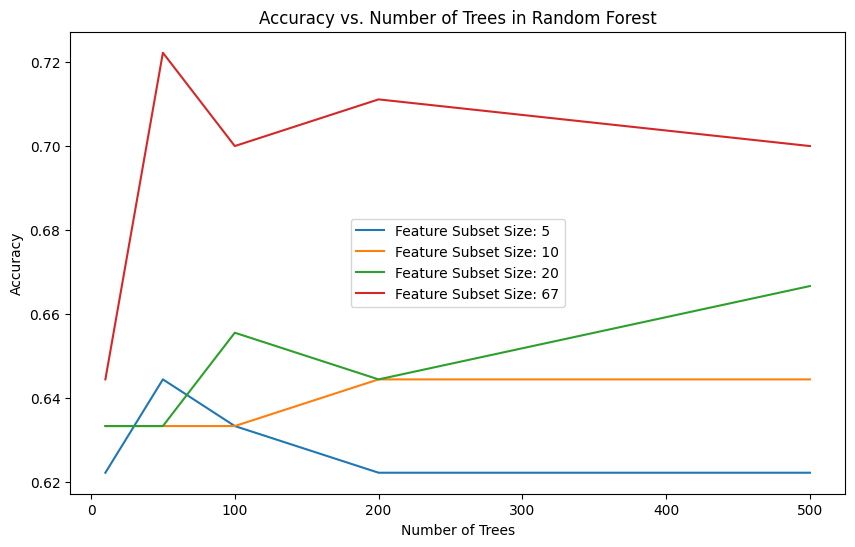

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set the different feature subset sizes
feature_subset_sizes = [5, 10, 20, len(feats_on_corr)]

# Set the different number of trees to test
num_trees = [10, 50, 100, 200, 500]

accuracy_scores = []

# Iterate through the different feature subsets
for subset_size in feature_subset_sizes:
    # Select the current feature subset
    selected_features = feats_on_corr[:subset_size]
    X_subset = X[selected_features]

    accuracy_scores_subset = []

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

    for n_trees in num_trees:
        # Initialize the RandomForestClassifier with bootstrap and oob_score enabled
        rfc = RandomForestClassifier(n_estimators=n_trees, bootstrap=True, oob_score=True, random_state=42)

        # Fit the model to the training data
        rfc.fit(X_train, y_train)

        # Predict the target for the test data
        predictions = rfc.predict(X_test)

        # Calculate the accuracy score for the current number of trees
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores_subset.append(accuracy)

        # Calculate precision, recall, and F1-score for each class
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average="weighted", zero_division=1)

        # Print the metrics for each class
        print(f"Metrics for Feature Subset Size: {subset_size}, Num Trees: {n_trees}")
        print("Class\t\tPrecision\tRecall\t\tF1-Score")
        print(f"Weighted\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}")
        print()

    accuracy_scores.append(accuracy_scores_subset)

# Create a graph of accuracy versus the number of trees for each feature subset
plt.figure(figsize=(10, 6))
for i, subset_size in enumerate(feature_subset_sizes):
    plt.plot(num_trees, accuracy_scores[i], label=f"Feature Subset Size: {subset_size}")

plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Trees in Random Forest")
plt.legend()
plt.show()


## Gradient Boosting Regressor Features

Metrics for Feature Subset Size: 5, Num Trees: 10
Class		Precision	Recall		F1-Score
Weighted	0.6316		0.7000		0.6506
--------------------------------------------------
Metrics for Feature Subset Size: 5, Num Trees: 50
Class		Precision	Recall		F1-Score
Weighted	0.6187		0.6889		0.6506
--------------------------------------------------
Metrics for Feature Subset Size: 5, Num Trees: 100
Class		Precision	Recall		F1-Score
Weighted	0.6818		0.7000		0.6730
--------------------------------------------------
Metrics for Feature Subset Size: 5, Num Trees: 200
Class		Precision	Recall		F1-Score
Weighted	0.6517		0.7000		0.6652
--------------------------------------------------
Metrics for Feature Subset Size: 5, Num Trees: 500
Class		Precision	Recall		F1-Score
Weighted	0.6582		0.7000		0.6679
--------------------------------------------------
Metrics for Feature Subset Size: 10, Num Trees: 10
Class		Precision	Recall		F1-Score
Weighted	0.5366		0.6222		0.5594
---------------------------------------------

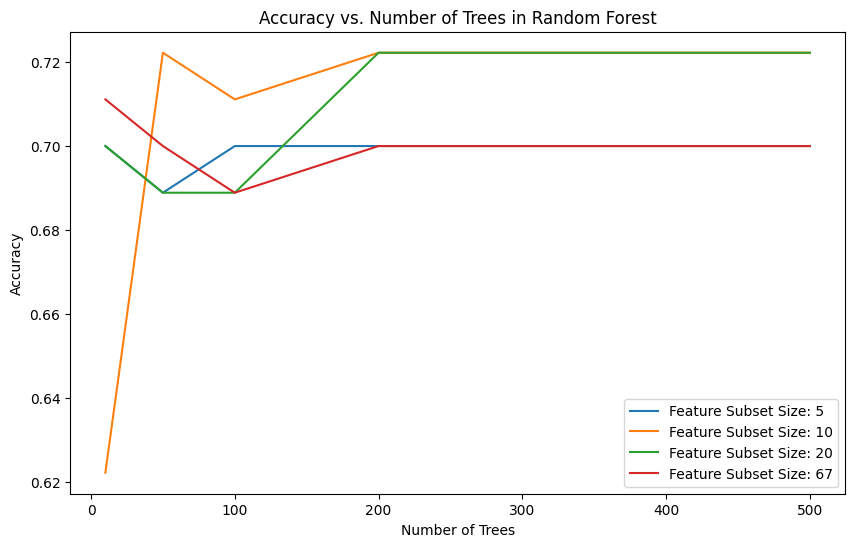

In [ ]:
# Set the different feature subset sizes
feature_subset_sizes = [5, 10, 20, len(feats_on_gb)]

# Set the different number of trees to test
num_trees = [10, 50, 100, 200, 500]

accuracy_scores = []

# Iterate through the different feature subsets
for subset_size in feature_subset_sizes:
    # Select the current feature subset
    selected_features = feats_on_gb[:subset_size]
    X_subset = X[selected_features]

    accuracy_scores_subset = []

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

    for n_trees in num_trees:
        # Initialize the RandomForestClassifier with bootstrap and oob_score enabled
        rfc = RandomForestClassifier(n_estimators=n_trees, bootstrap=True, oob_score=True, random_state=42)

        # Fit the model to the training data
        rfc.fit(X_train, y_train)

        # Predict the target for the test data
        predictions = rfc.predict(X_test)

        # Calculate the accuracy score for the current number of trees
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores_subset.append(accuracy)

        # Calculate precision, recall, and F1-score for each class
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average="weighted", zero_division=1)

        # Print the metrics for each class
        print(f"Metrics for Feature Subset Size: {subset_size}, Num Trees: {n_trees}")
        print("Class\t\tPrecision\tRecall\t\tF1-Score")
        print(f"Weighted\t{precision:.4f}\t\t{recall:.4f}\t\t{f1:.4f}")
        print('-' * 50)

    accuracy_scores.append(accuracy_scores_subset)

# Create a graph of accuracy versus the number of trees for each feature subset
plt.figure(figsize=(10, 6))
for i, subset_size in enumerate(feature_subset_sizes):
    plt.plot(num_trees, accuracy_scores[i], label=f"Feature Subset Size: {subset_size}")

plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Trees in Random Forest")
plt.legend()
plt.show()
